# **Bibliotecas**

---

In [ ]:
# Importação de todas as bibliotecas que serão utilizadas nesta etapa do notebook 
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import spacy
from spacy.util import minibatch
import random

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **Aquisição de Dados**

---

In [ ]:
# Leitura dos dados que serão utilizados
df = pd.read_csv('../data/01_raw/products_dataset.csv') 
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


# **Processando Dataset**

---

### Removendo valores nulos

In [ ]:
# Salva em 'numericos' todos os nomes das colunas que não são do tipo object
numericos = df.select_dtypes(exclude='object').columns
numericos 

Index(['product_id', 'seller_id', 'search_page', 'position', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts'],
      dtype='object')

In [ ]:
# Remove valores faltantes das variáveis que são só numéricas, substituindo por 0
df[numericos] = df[numericos].fillna(0)

In [ ]:
# Salva em strings todos os nomes das colunas que são do tipo object 
strings = df.select_dtypes(include='object').columns
strings

Index(['query', 'title', 'concatenated_tags', 'creation_date', 'category'], dtype='object')

In [ ]:
# Remove valores faltantes das variáveis que não são numéricas e substitui por 0, como texto
df[strings] = df[strings].fillna('0')

### Separando em dados de treino e teste

Antes da separação o dataset será ordenado pela data, assim as classificações serão feitas para os valores com a data mais atual. Com isso, será utilizado o parâmetro `shuffle` para que a divisão seja feita na ordem.

In [ ]:
df_ordenado = df.sort_values(by='creation_date', ignore_index=True)
df_ordenado.head(2)

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,14229551,5243703,sacola de papel kraft,1,21,Sacola kraft media c/ papel rendado,sacolas papel coloridas niver anna's,2008-11-05 22:57:17,12.26,6.0,0,4,129,7.0,Papel e Cia
1,1125256,9711820,porta retrato com palitos de sorvete,1,19,CAIXA PORTA-CHÁ,artesanato palitos sorvete,2008-11-10 17:43:17,83.94,0.0,0,4,23,7.0,Papel e Cia


In [ ]:
# Divisão em treino e teste
label = df_ordenado["category"].copy()
feat_colunas = df_ordenado.columns.tolist()
feat_colunas.remove("category")
feats = df_ordenado[feat_colunas].copy()

X_train, X_test, y_train, y_test = train_test_split(feats, label, random_state=0, shuffle=False)

In [ ]:
# Verifica o tamanho dos conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28880, 14), (9627, 14), (28880,), (9627,))

In [ ]:
X_train.tail(2)

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
28878,7903614,9377206,dia dos pais,1,24,Chinelo Dia dos Pais 2ª linha,chinelo dia pais dora personalizado dia pais p...,2018-06-28 18:24:50,14.160000,287.0,1,20,476,27.0
28879,11573689,9377206,lembrancinha masculina,2,2,Chinelo dia Dos professores 2ª linha,chinelo dia professores dia professores,2018-06-28 18:31:08,15.059999,289.0,1,20,137,24.0


In [ ]:
X_test.head(2)

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
28880,8428008,9159926,forma para placa cimento 3d,1,35,Forma em Silicone p/ Gesso 3D Malm | Medusa 29x29,placas,2018-06-28 18:38:49,95.41,2000.0,0,10,125,21.0
28881,4233862,6341935,saquinho maternidade,3,4,6 Saquinhos Maternidade com viés Azul Marinho Poá,saquinhos maternidade,2018-06-28 18:56:26,119.07,42.0,1,6,230,6.0


# **Treinando o Modelo com NLP**

---

Resolvemos usar o NLP para classificar o dataframe, pois gostaríamos de ver uma forma mais automática para classificação e ver como um IA se comportaria para classificar o dataframe, uma vez que o NLP é muito usado e recomendado para classificar palavras. 

In [ ]:
# Criando um modelo vazio em português
nlp = spacy.blank("pt")

# Criando um Categorizador de Texto com classe exclusiva e arquitetura "bow" 
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "bow"})

# Adicioando o Categorizador de Texto para o modelo vazio
nlp.add_pipe(textcat)

In [ ]:
# Exibição das categorias para colocar no TextCat, na célula abaixo
df.category.unique()

array(['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas',
       'Bijuterias e Jóias'], dtype=object)

In [ ]:
# Adicionando as Categorias nos Textcat que serão usados para categorizar os objetos
textcat.add_label("Lembrancinhas")
textcat.add_label("Decoração")
textcat.add_label("Bebê")
textcat.add_label("Papel e Cia")
textcat.add_label("Outros")
textcat.add_label("Bijuterias e Jóias")

1

In [ ]:
# Criando o train text e o train label
train_texts = X_train['title'].values
train_labels = [{'cats': {'Lembrancinhas': label == 'Lembrancinhas',
                          'Decoração': label == 'Decoração',
                          'Bebê': label == 'Bebê',
                          'Papel e Cia': label == 'Papel e Cia',
                          'Outros': label == 'Outros',
                          'Bijuterias e Jóias': label == 'Bijuterias e Jóias'}} 
                for label in y_train]

In [ ]:
# Criando o train_data e vendo como que o ML está classificando os train texts (data de treino)
train_data = list(zip(train_texts, train_labels))
train_data[:3]

[('Sacola kraft media c/ papel rendado',
  {'cats': {'Bebê': False,
    'Bijuterias e Jóias': False,
    'Decoração': False,
    'Lembrancinhas': False,
    'Outros': False,
    'Papel e Cia': True}}),
 ('CAIXA PORTA-CHÁ',
  {'cats': {'Bebê': False,
    'Bijuterias e Jóias': False,
    'Decoração': False,
    'Lembrancinhas': False,
    'Outros': False,
    'Papel e Cia': True}}),
 ('Lembrancinha batizado',
  {'cats': {'Bebê': False,
    'Bijuterias e Jóias': False,
    'Decoração': False,
    'Lembrancinhas': True,
    'Outros': False,
    'Papel e Cia': False}})]

In [ ]:
# Configuramos as opções e otimizador para treinamento
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Criando o batch generator com batch size = 8
batches = minibatch(train_data, size=8)

# Fazendo iteração pelo minibatches
for batch in batches:
    # Cada batch é uma lista de (text, label) mas precisamos para
    # enviar listas separadas para texts e labels para atualizar().
    # Esse é um rápido modo de dividir a lista de tuplas em listas
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)

In [ ]:
# Configuramos as opções e otimizador para treinamento, realizando 10 épocas  
random.seed(0)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
    random.shuffle(train_data)
    # Criando o batch generator com batch size = 8
    batches = minibatch(train_data, size=8)
    # Iteração pelo minibatches
    for batch in batches:
        # Cada batch é uma lista de (text, label) mas precisamos para
        # enviar listas separadas para texts e labels para update().
        # Esse é um rápido modo de dividir a lista de tuplas em listas
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
        
    print(losses)

{'textcat': 10.475832303750849}
{'textcat': 19.570072548530334}
{'textcat': 27.696671089534902}
{'textcat': 35.13895884835881}
{'textcat': 42.06172706948689}
{'textcat': 48.58467892462147}
{'textcat': 54.775461937283495}
{'textcat': 60.70066163237814}
{'textcat': 66.38584396434172}
{'textcat': 71.87301528637997}


In [ ]:
# Separando os textos de teste e transformando em valores numéricos 
texts = X_test['title']
docs = [nlp.tokenizer(text) for text in texts]
    
# Usa o textcat para pegar os scores de cada doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[6.4351101e-04 5.4126930e-01 1.9933976e-04 6.7841476e-03 4.5003352e-01
  1.0701756e-03]
 [5.7540601e-04 1.2561283e-03 9.9785727e-01 1.0023389e-04 1.3814162e-04
  7.2789691e-05]
 [5.7540601e-04 1.2561283e-03 9.9785727e-01 1.0023389e-04 1.3814162e-04
  7.2789691e-05]
 ...
 [9.9732071e-01 2.6330943e-07 1.8371526e-06 2.6700643e-03 7.2764665e-06
  2.4724569e-09]
 [1.7811103e-04 6.0905032e-03 9.6960586e-01 1.9920648e-04 2.3920592e-02
  5.7215552e-06]
 [6.6335273e-01 3.2917915e-03 3.2928795e-01 2.6020543e-03 1.4595924e-03
  5.8169439e-06]]


In [ ]:
# Pelos scores, achou-se o label com os mais altos scores/probabilidades  
predicted_labels = scores.argmax(axis=1)
cat_prev = []
for label in predicted_labels: 
    cat_prev.append(textcat.labels[label])
cat_prev[:5]

['Decoração', 'Bebê', 'Bebê', 'Bebê', 'Lembrancinhas']

# **Validando modelo**

---

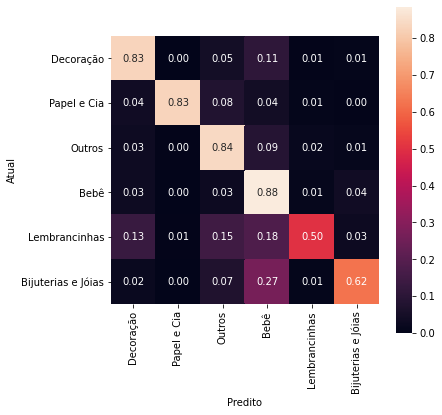

In [ ]:
# Criando a Matriz de Confusão para verificar como ficou o treinamento do meu modelo
target_names = df.category.unique()
cm = confusion_matrix(y_test, cat_prev)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, square=True)
plt.ylabel('Atual')
plt.xlabel('Predito')
plt.show(block=False)

## **Conclusão**

Utilizando a biblioteca `spacy`, obteve-se um modelo com desempenho razoável, mesmo somente com a coluna `title` e sem balancear os dados, visando que não foi realizado nenhum pré-processamento, porque a biblioteca já trata os dados textuais internamente. Vale ressaltar o tempo maior que é gasto no treinamento do modelo, em comparação aos três modelos utilizados anteriormente.